### LeNet (Convolutional Neural Net)  
Roger Wang  
UCLA  
Application of LeNet CNN architecture on FashionMNIST

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import SGD
from tqdm import tqdm

In [2]:
# FashionMNIST dataset
class FashionMNIST():
    def __init__(self, root='../data', batch_size=64, resize=(28,28)):
        self.batch_size = batch_size
        self.resize = resize

        # image transforms, resize and convert to tensor
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])

        # initialize train (60k) and val (10k) sets
        self.train = torchvision.datasets.FashionMNIST(root=root,train=True,transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(root=root,train=False,transform=trans,download=True)

    # data loader for dataset
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return DataLoader(data, self.batch_size, shuffle=train)
    
    # getting training data
    def train_dataloader(self):
        return self.get_dataloader(True)
    
    # getting val data
    def val_dataloader(self):
        return self.get_dataloader(False)

In [2]:
# conv block used in LeNet
class ConvBlock(nn.Module):
    def __init__(self, channels, c_kernel, c_stride, c_padding, p_kernel, p_stride):
        super().__init__()
        
        self.net = nn.Sequential(nn.LazyConv2d(channels,c_kernel,c_stride,c_padding),
                                 nn.ReLU(),
                                 nn.MaxPool2d(p_kernel,p_stride))

    def forward(self,x):
        return self.net(x)

# LeNet architecture w/ ReLU, max pooling, and softmax
class LeNet(nn.Module):
    def __init__(self, outputs, lr, momentum, weight_decay):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        self.net = nn.Sequential(ConvBlock(6,5,1,2,2,2), # conv: 6 channels, kernel=5 w 1 stride and 2 padding, pool: kernel = 2, stride 2
                                 ConvBlock(16,5,1,0,2,2), # conv: 16 channels no padding
                                 nn.Flatten(),
                                 nn.LazyLinear(120), nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.LazyLinear(84), nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.LazyLinear(outputs),
                                 nn.Dropout(0.5), # dropout on output layer as shown in MLP notebook increases acc
                                 )

    def forward(self, x):
        return self.net(x)

    # cross-entropy loss
    def loss(self, batch):
        logits, labels = batch
        return F.cross_entropy(logits, labels) # mean reduction default

    def accuracy(self, batch, averaged=True):
        logits, labels = batch
        logits, labels = logits.to('cpu'), labels.to('cpu')
        predict = self.predict(logits).type(labels.dtype)
        compare = (predict == labels).type(torch.float32) # bc predict now on cpu
        return compare.mean() if averaged else compare

    def predict(self, logits):
        return logits.argmax(axis=1) # issue w argmax on gpu

    def initOptimizer(self):
        self.optim = SGD(self.parameters(), self.lr, self.momentum, self.weight_decay)

In [3]:
# early stopper and training loop

# early stopping class
# criterion: validation accuracy
class EarlyStop():
    def __init__(self, patience, delta=0.003):
        self.patience = patience
        self.delta = delta
        self.best = 0
        self.count = 0

    def checkForStop(self, acc):
        if acc > self.best:
            self.best = acc
            self.count = 0
            return False
        elif acc < self.best-self.delta:
            if self.count > self.patience:
                return True
            self.count = self.count + 1
            return False
        
# training loop
def train(model, trainloader, valloader, epochs):
    train_loss = []
    val_loss = []
    val_acc = []
    model.initOptimizer()
    mps = torch.device('mps')
    model.to(mps)
    stopper = EarlyStop(3)

    pbar = tqdm(range(epochs))
    for i in range(epochs):
        train_loss.append(0)
        val_loss.append(0)
        val_acc.append(0)

        model.train()
        # training over batches of train set
        for n, (traindata,trainlabel) in enumerate(trainloader):
            traindata, trainlabel = traindata.to(mps), trainlabel.to(mps)
            model.optim.zero_grad()
            logits = model.forward(traindata)
            loss = model.loss((logits,trainlabel))
            loss.backward()
            model.optim.step()

            train_loss[i] = train_loss[i] + loss.item()
        train_loss[i] = train_loss[i] / len(trainloader)

        # validation over batches of val set
        model.eval()
        for n, (val,vallabel) in enumerate(valloader):
            val, vallabel = val.to(mps), vallabel.to(mps)
            with torch.no_grad():
                logits = model.forward(val)
                loss = model.loss((logits,vallabel))
                # accuracy needs to be computed on CPU???
                accuracy = model.accuracy((logits,vallabel))

                val_loss[i] = val_loss[i] + loss.item()
                val_acc[i] = val_acc[i] + accuracy
        val_loss[i] = val_loss[i] / len(valloader)
        val_acc[i] = val_acc[i] / len(valloader)

        # update pbar
        pbar.update(1)
        pbar.set_description(f'val_acc: {val_acc[i]:.3f} train_loss: {train_loss[i]:.3f}')

        # check for early stopping
        if stopper.checkForStop(val_acc[i]):
            break

    pbar.close()

    # display loss and acc
    #plt.plot(train_loss, label='train_loss')
    #plt.plot(val_loss, label='val_loss')
    plt.plot(val_acc)
    plt.xlabel('epoch')
    #plt.legend()

In [47]:
# initialize dataset and model
mps = torch.device('mps')
data = FashionMNIST(batch_size=128)
model = LeNet(10,lr=0.1,momentum=0.5,weight_decay=0.5)
model.to(mps)

/Users/rogerwang/opt/anaconda3/envs/torchKernel/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LeNet(
  (net): Sequential(
    (0): ConvBlock(
      (net): Sequential(
        (0): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): LazyLinear(in_features=0, out_features=120, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): LazyLinear(in_features=0, out_features=84, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): LazyLinear(in_features=0, out_features=10, bias=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Softmax(dim=1)
  )
)

val_acc: 0.860 train_loss: 1.908:  71%|███████   | 71/100 [09:36<03:55,  8.12s/it]


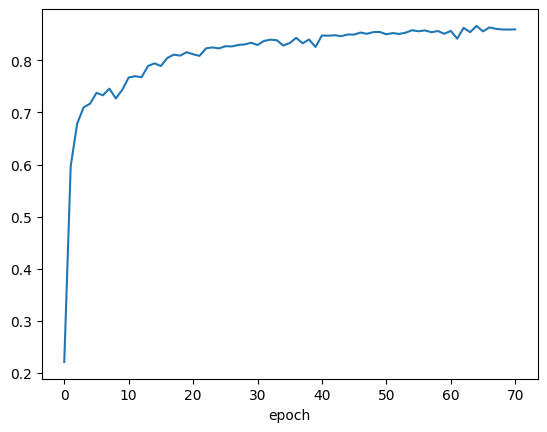

In [21]:
# train
train(model,data.train_dataloader(),data.val_dataloader(),epochs=100)

notes during training:  
Original LeNet model higher accuracy than MLP, 0.844 vs 0.758 (without output dropout) 

Added dropout to FC layers to improve score and reduce overfitting, increased score to 0.86 and as high as 0.874, early stoppage in training loop    

LeNet has similar accuracy to MLP but trained in much less time/epochs  

Dropout was added after output layer which lead to higher val accuracy at 0.883  
Similar results were seen when adding dropout to output layer of MLP which had accuracy of 0.860  

I hypothesize that noise in target labels contributes to the increase in validation accuracy when adding dropout to the output layer. For example, several categories are visually ambigious, and would be difficult even for me to perfectly categorize, examples: pullover, coat   

This shows that label noise and ambiguity make FashionMNIST a good dataset to use dropout at the output layer